# Import packages and set settings

In [4]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.insert(1, './python_mods/')
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
import collections

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Functions

In [9]:


def recalc_mses(model_fxns, EA_theta_set, exp_data, exp_time, params_constants, initials, ptpD=False):
    mses = []
    for params in EA_theta_set:
        mses.append(sum(model_supp.calc_sim_score(model_fxns, params, exp_data, exp_time, params_constants, initials, ptpD)[:18]))
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = EA_theta_set[re_idx]
    mses = np.sort(mses)
    return mses, thetas

def sort_mses_thetas(mses, thetas):
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = thetas[re_idx]
    return np.sort(mses), thetas

def calc_mse(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=False):
    # Takes 
    return sum(model_supp.calc_sim_score(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD)[:18]) ##AMY (insert your own error function)

def def_schedules(sorted_mses):
    best_mse = sorted_mses[0]
    worst_mse = sorted_mses[-1]
    
#     e1 = (best_mse+worst_mse)/2 #will take longer to run
    e1 = worst_mse
    e2 = (e1+best_mse)/2
    e3 = (e2+best_mse)/2
    e4 = (e3+best_mse)/2
#     e5 = (e4+best_mse)/2
    return e1, e2, e3, e4
    
def scaled_prob_mses(mses, top=.99, bot=.01):
    # mses is SORTED 
    scale = [(top-bot)*(x-mses[0])/(mses[-1]-mses[0])+bot for x in mses]
    inv = [1/x for x in scale]
    probs = [x/sum(inv) for x in inv]
    return probs

def draw_thetas(sorted_params, probs):
    idx = np.random.choice(range(len(sorted_params)), 1, p=probs)
    return sorted_params[idx][0]

def step_theta(theta):
    log_theta = np.log10(theta) 
    theta_prime = np.concatenate([10**(np.random.uniform(x-.1,x+.1,1)) for x in log_theta], axis=0)
    return theta_prime

def run_schedule(prior_thetas, probs, ei, num_theta_primes):
    thetas_ei = []
    mses_ei = []
    c = collections.Counter({'Pass': 0, 'Fail': 0}) 
    while len(thetas_ei) < num_theta_primes:
        theta = draw_thetas(prior_thetas, probs)
        theta_prime = step_theta(theta)
        mse = calc_mse(M2b_fxns, theta_prime, exp_data, exp_time, params_constants, initials, ptpD=False) ##AMY error fxn
        if mse < ei:
            c['Pass'] += 1
            thetas_ei.append(theta_prime)
            mses_ei.append(mse)
            if len(mses_ei) % int(num_theta_primes*.1) == 0:
                print(str(int(len(mses_ei)/num_theta_primes*100)) + "% complete.") 
        else:
            c['Fail'] += 1
    return np.asarray(mses_ei), np.asarray(thetas_ei), c

# Model

## Model Functions

In [8]:
from scipy.optimize import fsolve
from scipy.integrate import odeint

In [12]:
# def simulate_t100a_experiment_M2b_kb(m, inits, total_protein, sig, learned_params, time,  run_type=None):
#         beta_3, alpha, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params #17
#         learned_params = beta_3, 0, kb, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
#         #solve odes:
#         odes = odeint(m, inits, time, args=(total_protein, sig, learned_params, run_type))
#         return odes

# def simulate_nopos_experiment_M2b_kb(m, inits, total_protein, sig, learned_params, time,  run_type=None):
#     beta_3, alpha, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params #17
#     learned_params = beta_3, 0, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
#     #solve odes:
#     odes = odeint(m, inits, time, args=(total_protein, sig, learned_params, run_type))
#     return odes

# def M2b_kb(initials,t,total_protein,sig,params, run_type=None):
# #     if run_type:
# #         if run_type[0] == 'ramp':
# #             sig = signal_ramp_special(t)
# #         elif run_type[0] == 'rand':
# #             sig = get_ramp_signal(t, run_type[1])
# #         elif run_type[0] == 'man':
# #             sig = get_manual_signal(t)

#     MAP3K, MAP2K, MAPK, gly = initials
#     MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
#     beta_3, alpha, kb, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params #17

#     MAP3K_I = MAP3K_t-MAP3K
#     MAP2K_I = MAP2K_t-MAP2K
#     MAPK_I = MAPK_t-MAPK
#     # PTP_I = PTP_t-PTP

#     dMAP3K = (((sig*k1 + kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
#     dMAP2K = (((k3*MAP3K + MAPK*alpha)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K)) #bug
#     dMAPK = (((k5)*MAP2K)*MAPK_I)/(K_5+MAPK_I) - (k6*MAPK)/(K_6+MAPK)
#     dgly = s7*MAPK - d8*gly

#     return dMAP3K, dMAP2K, dMAPK, dgly

# def run_ss(m, inits, total_protein, learned_params):
#     ss = fsolve(m, inits, args=(0,total_protein, 0, learned_params))
#     return ss

# def simulate_wt_experiment(m, inits, total_protein, sig, learned_params, time, run_type=None):
#     odes = odeint(m, inits, time, args=(total_protein, sig, learned_params, run_type))
#     return odes

# def molarity_conversion(molecules):
#     Na = 6.02214076*10**23
#     cell_volume = 44                                                                 # approx volume of a SC yeast cell
#     return molecules/(Na*cell_volume*10**-15)*1000000 

# class Model():
#     def __init__(self, m, t100a, nopos=None):
#         self.m = m
#         self.t100a = t100a
#         self.nopos = nopos
     



## Model Variables (Constants)

In [10]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)


MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on


labelnames = ['$- fb$', '$+ fb$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']


minimums = [-4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, -4, -4]

maximums = [ 4, 4, 4, 
        4, 4, 4, 4,
        4, 4, 4, 4, 
        4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

initials = [MAP3K, MAP2K, MAPK, gly]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]

# Load experimental data

In [11]:
exp_data, exp_time = model_supp.get_data()

mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, hog1_ramp_inhib_data, pbs2_ramp_data, mapk_ptpD_data = exp_data
mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time 

mapk_data_t100a_0 = [mapk_t100a_data[0]] 
mapk_time_t100a_0 = [0, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_t100a_data = [mapk_t100a_data[1], mapk_t100a_data[2]] # exculde 0 because different timescale

# Load simulation data

In [12]:
model_fxns = model.Model(model.M2b_kb, model.simulate_t100a_experiment_M2a_kb, model.simulate_nopos_experiment_M2a_kb, model.M2b_kb_on_off)

In [7]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191205_kb_M2b/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)



Number of runs collected: 2000
Best last gen MSE: 1857.0865576680335
Mean last gen MSEs of top 5%: 2748.9522786570324


In [8]:
## sort
M2b_sorted_mses_EA, M2b_sorted_thetas_EA = sort_mses_thetas(last_mses, last_params)

# Check EA results

No handles with labels found to put in legend.


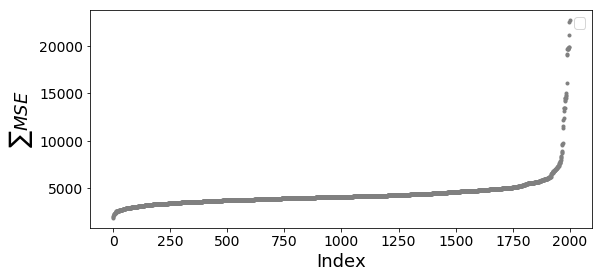

In [9]:
plotting.plt_idx_vs_mse(M2b_sorted_mses_EA, len(M2b_sorted_mses_EA))

No handles with labels found to put in legend.


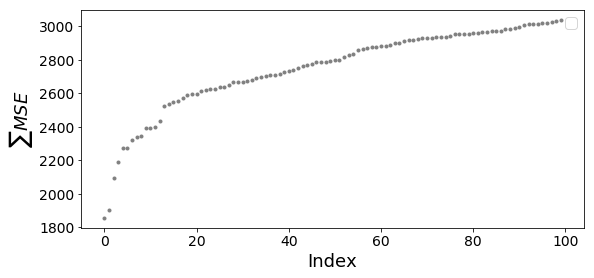

In [10]:
plotting.plt_idx_vs_mse(M2b_sorted_mses_EA, 100)

<Figure size 720x576 with 0 Axes>

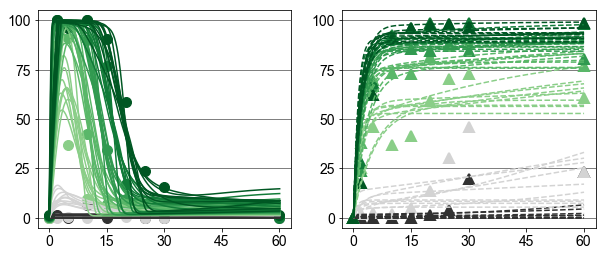

In [11]:
# original parameter values
plotting.plt_param_behaviors(M2b_fxns, M2b_sorted_thetas_EA, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

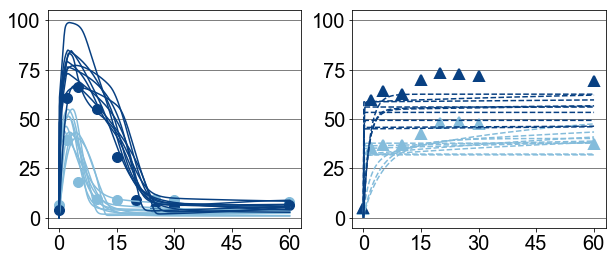

In [15]:
plotting.plt_param_behaviors(M2b_fxns, M2b_sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

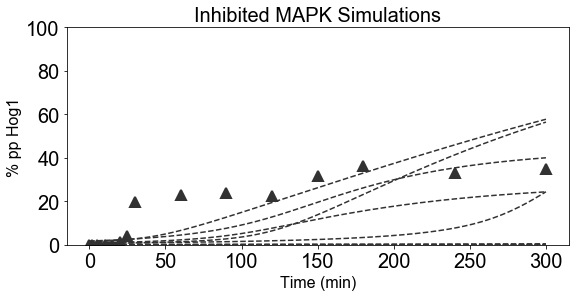

In [16]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2b_fxns, M2b_sorted_thetas_EA, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

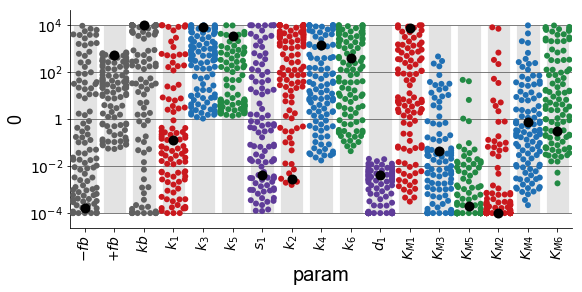

In [17]:
df_top_thetas_EA = pd.DataFrame(M2b_sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(M2b_sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

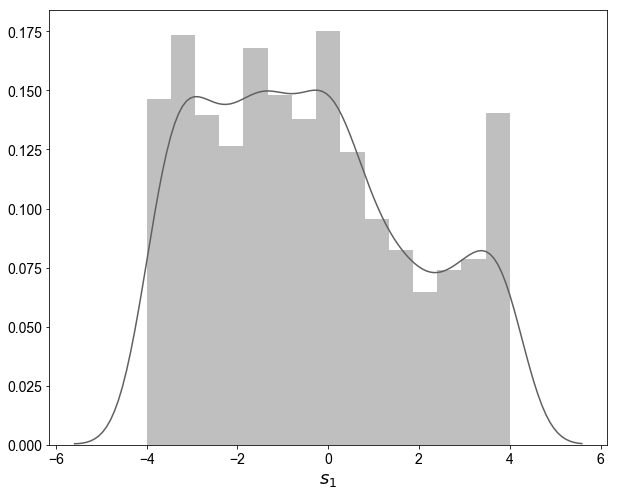

In [18]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[6]]))

In [87]:
sims_M2b_kb_ea = plotting.simdata_to_df(M2b_fxns, M2b_sorted_thetas_EA, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


10% complete.
20% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


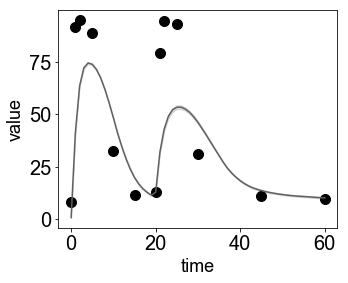

In [88]:
plotting.plt_ramp_cis(sims_M2b_kb_ea, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

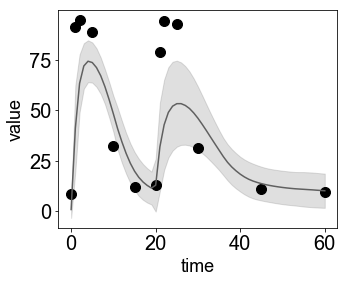

In [89]:
plotting.plt_ramp_cis(sims_M2b_kb_ea, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Turning MAPK activity on and off

In [158]:
M2b_fxns = model.Model(model.M2b_kb, model.simulate_t100a_experiment_M2a_kb, model.simulate_nopos_experiment_M2a_kb, model.M2b_kb_on_off)

In [163]:
M2b_inhib_sims = plotting.inhibdata_to_list(M2b_fxns, thetas_e2_sort, params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


20% complete.
30% complete.
40% complete.
50% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


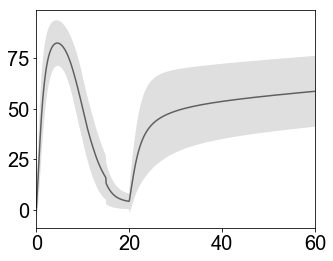

In [164]:
plotting.plt_inhib_cis(M2b_inhib_sims, time, ci="sd") #t>15 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


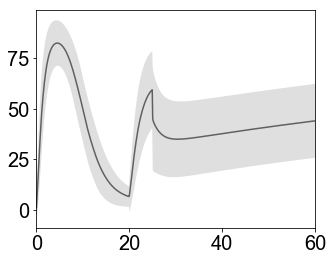

In [162]:
plotting.plt_inhib_cis(M2b_inhib_sims, time, ci="sd") #t>25 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


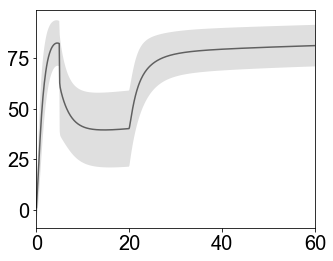

In [160]:
plotting.plt_inhib_cis(M2b_inhib_sims, time, ci="sd") #t>5 with ramp

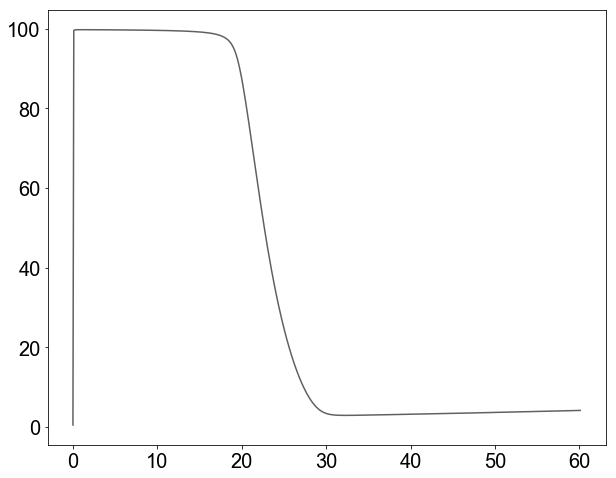

In [123]:
odes = odeint(model.M2b_kb, initials, time, args=(params_constants, 550000, M2b_sorted_thetas_EA[0]))
active = odes[:,2]/params_constants[2]*100
plt.plot(time, active)

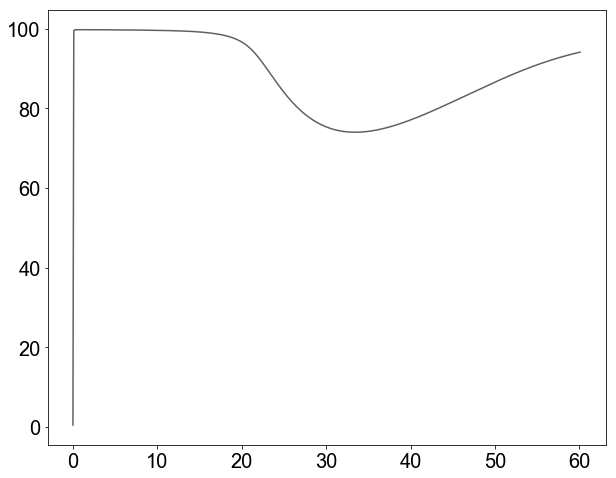

In [130]:
odes = odeint(model.M2b_kb_on_off, initials, time, args=(params_constants, 550000, M2b_sorted_thetas_EA[0]))
active = odes[:,2]/params_constants[2]*100
plt.plot(time, active)

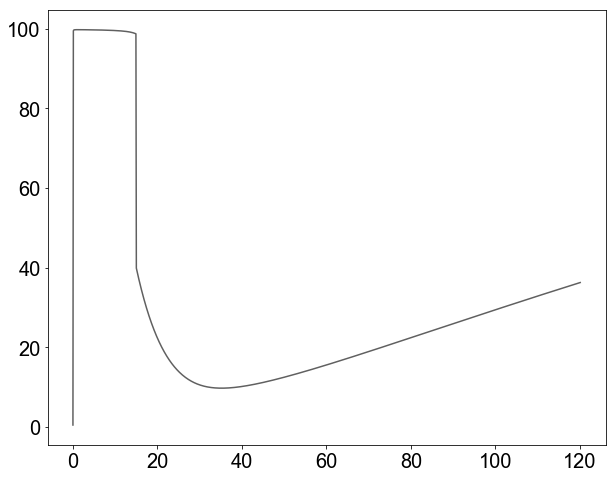

In [147]:
dt = 0.1
steps = 1201
time = np.linspace(0,dt*steps,steps)


odes = odeint(model.M2b_kb_on_off, initials, time, args=(params_constants, 450000, M2b_sorted_thetas_EA[0]))
active = odes[:,2]/params_constants[2]*100
plt.plot(time, active)

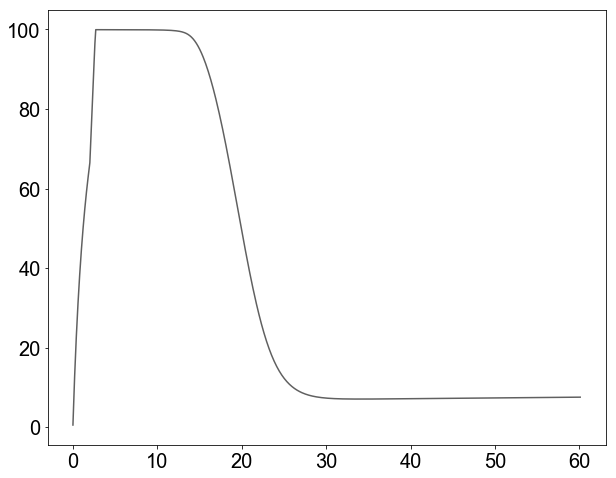

In [146]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)


odes = odeint(model.M2b_kb_on_off, initials, time, args=(params_constants, 450000, M2b_sorted_thetas_EA[1]))
active = odes[:,2]/params_constants[2]*100
plt.plot(time, active)

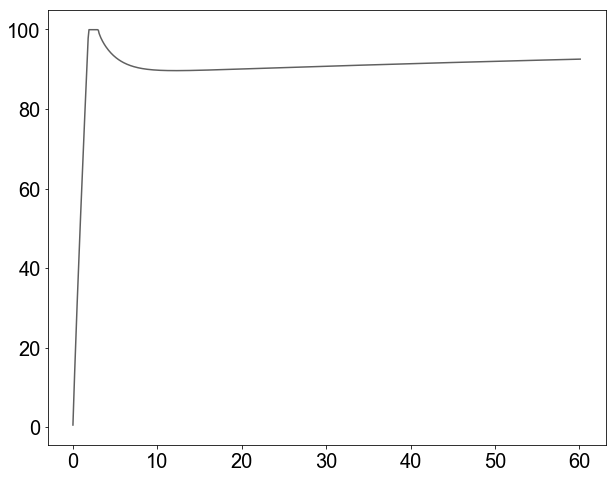

In [151]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)


odes = odeint(model.M2b_kb_on_off, initials, time, args=(params_constants, 450000, M2b_sorted_thetas_EA[1]))
active = odes[:,2]/params_constants[2]*100
plt.plot(time, active)

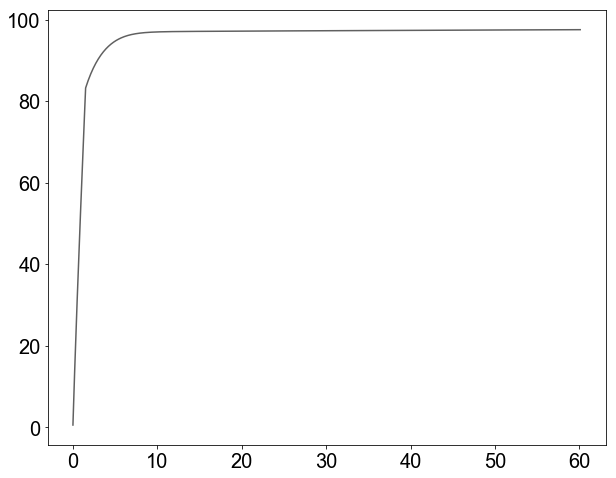

In [155]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)


odes = odeint(model.M2b_kb_on_off, initials, time, args=(params_constants, 450000, M2b_sorted_thetas_EA[1]))
active = odes[:,2]/params_constants[2]*100
plt.plot(time, active)

# SMC

## Try different sizes of EA 

I've been using top 500 and it's worked really well, but here I'm using top 20 so that it runs fast

In [14]:
M2b_new_mses_EA, M2b_new_thetas_EA = recalc_mses(M2b_fxns, M2b_sorted_thetas_EA, exp_data, exp_time, params_constants, initials)

print(M2b_new_mses_EA[:10])

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

[1945.04199845 2212.04904525 2301.79005922 2383.61652005 2475.25909775
 2485.11231408 2552.4704701  2566.79270532 2571.13577154 2577.79590007]


No handles with labels found to put in legend.


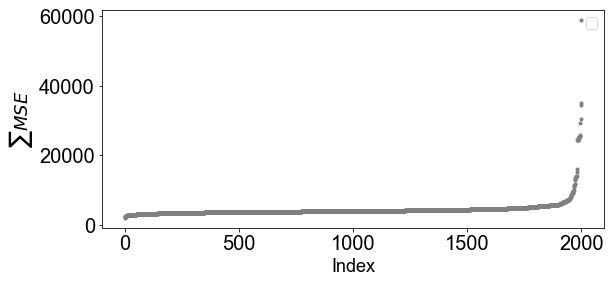

In [15]:
plotting.plt_idx_vs_mse(M2b_new_mses_EA, len(M2b_new_mses_EA))

In [16]:
M2b_EA_thetas_1perc = M2b_new_thetas_EA[:500]
M2b_EA_mses_1perc = M2b_new_mses_EA[:500]

## Define schedules

I've been messing around with where I start with the schedule and how many schedules to run

In [18]:
e1, e2, e3, e4 = def_schedules(M2b_EA_mses_1perc)

print("Best MSE: " + str(M2b_EA_mses_1perc[0]))
print("Worst MSE: " + str(M2b_EA_mses_1perc[-1]))
print()
print("Schedules: " + str(e1),str(e2),str(e3),str(e4))
print()


Best MSE: 1945.0419984504829
Worst MSE: 3604.033159345544

Schedules: 3604.033159345544 2774.5375788980136 2359.7897886742485 2152.4158935623655



## Define probability

I've also been messing around with the `top` and `bot` params of `scaled_prob_mses`. 
- (.9 and .1) 
- (.95 and .05) 
- (.99 and .01)

I've noticed that with the larger number of EA thetas, the more extreme ranges are better. 
If you start with a small number of EA thetas, being more conservative with the ranges
results in more balanced probabilities.

In [19]:
probs = scaled_prob_mses(M2b_EA_mses_1perc, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])


[0.13418134274842228, 0.008000007460646113, 0.006078750168429849, 0.004986764803969797, 0.004151520954243015]
[0.0013566278949238594, 0.0013561536085331587, 0.0013559424593157956, 0.001355737566846956, 0.001355367098468912]


## Schedule 1

I use `num_theta_primes = 1000`, but set to 100 to be faster.

In [20]:
mses_e1, thetas_e1, count_e1 = run_schedule(M2b_EA_thetas_1perc, probs, e1, num_theta_primes=1000)
mses_e1_sort, thetas_e1_sort = sort_mses_thetas(mses_e1, thetas_e1)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

10% complete.


../../python_modules\model.py:335: RuntimeWarning: overflow encountered in double_scalars
  dMAPK = (((k5)*MAP2K)*MAPK_I)/(K_5+MAPK_I) - (k6*MAPK)/(K_6+MAPK)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20% complete.


../../python_modules\model.py:334: RuntimeWarning: overflow encountered in double_scalars
  dMAP2K = (((k3*MAP3K + MAPK*alpha)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
../../python_modules\model.py:333: RuntimeWarning: invalid value encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
../../python_modules\model.py:334: RuntimeWarning: invalid value encountered in double_scalars
  dMAP2K = (((k3*MAP3K + MAPK*alpha)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
../../python_modules\model.py:335: RuntimeWarning: invalid value encountered in double_scalars
  dMAPK = (((k5)*MAP2K)*MAPK_I)/(K_5+MAPK_I) - (k6*MAPK)/(K_6+MAPK)


30% complete.


../../python_modules\model.py:333: RuntimeWarning: divide by zero encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))


40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [21]:
df_top_thetas_e1 = pd.DataFrame(thetas_e1_sort)
df_top_thetas_e1.columns = labelnames

df_top_thetas_e1.to_csv('M2b_kb_thetas_e1.csv')

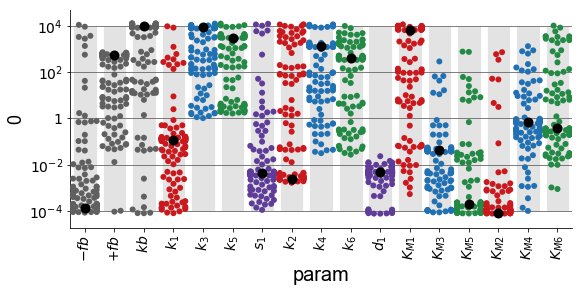

In [27]:
num_plt = 100
df_plt = pd.DataFrame(thetas_e1_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

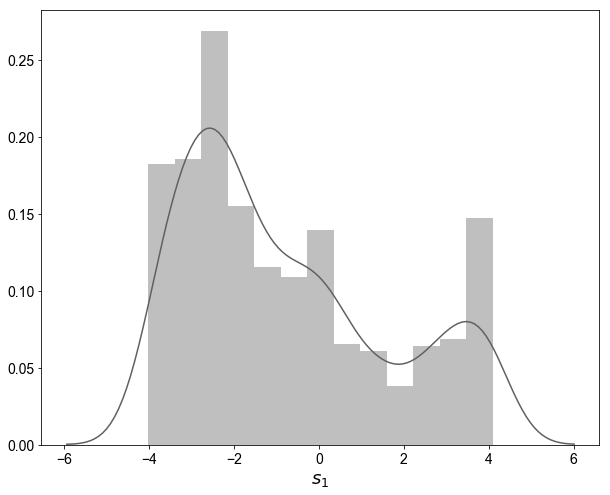

In [28]:
sns.distplot(np.log10(df_top_thetas_e1[labelnames[6]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

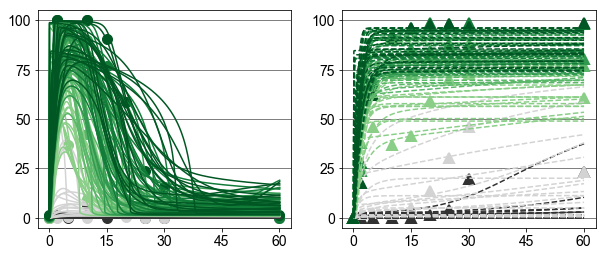

In [29]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e1, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

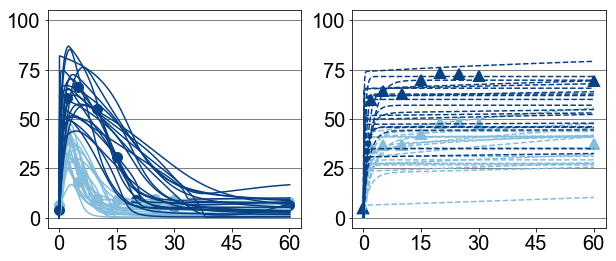

In [30]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e1, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [94]:
sims_M2b_kb_e1 = plotting.simdata_to_df(M2b_fxns, thetas_e1_sort, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


In [97]:
sims_M2b_kb_e1_l = plotting.simdata_to_list(M2b_fxns, thetas_e1_sort, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


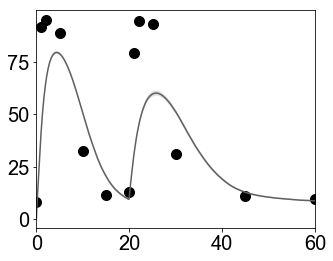

In [98]:
plotting.plt_ramp_cis(sims_M2b_kb_e1_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


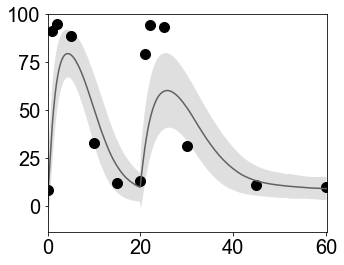

In [99]:
plotting.plt_ramp_cis(sims_M2b_kb_e1_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Schedule 2

Redefine probs based on results of last schedule.

In [22]:
probs = scaled_prob_mses(mses_e1_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.05123515848451298, 0.010234061659684067, 0.008409534766173012, 0.007611894663425287, 0.007053228614262245]
[0.0005182094356380141, 0.0005180182249871134, 0.0005179649608153525, 0.000517771211959453, 0.000517526853378919]


In [23]:
mses_e2, thetas_e2, count_e2 = run_schedule(thetas_e1_sort, probs, e2, num_theta_primes=1000)
mses_e2_sort, thetas_e2_sort = sort_mses_thetas(mses_e2, thetas_e2)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [24]:
df_top_thetas_e2 = pd.DataFrame(thetas_e2_sort)
df_top_thetas_e2.columns = labelnames

df_top_thetas_e2.to_csv('M2b_kb_thetas_e2.csv')

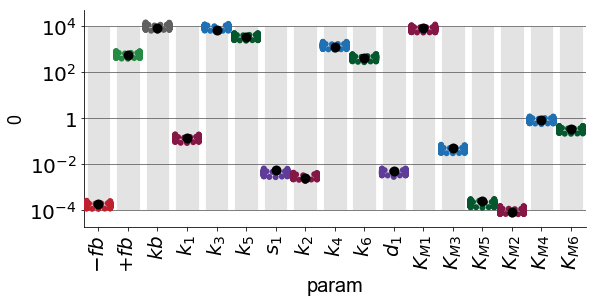

In [25]:
num_plt = 200
df_plt = pd.DataFrame(thetas_e2_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

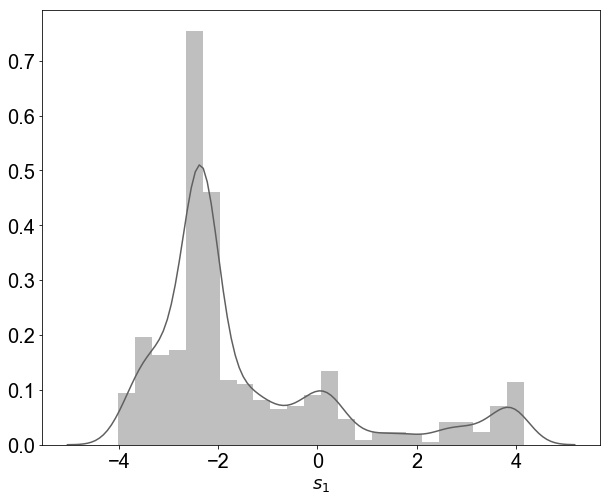

In [36]:
sns.distplot(np.log10(df_top_thetas_e2[labelnames[6]]))

<Figure size 720x576 with 0 Axes>

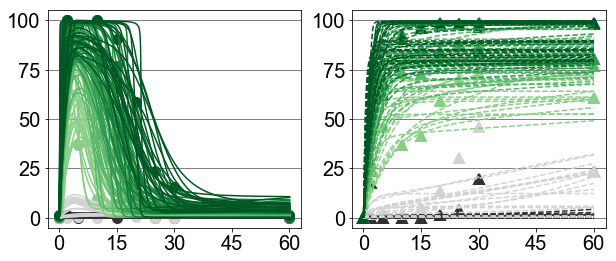

In [115]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

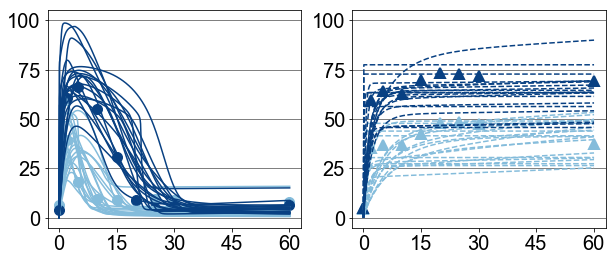

In [116]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [84]:
sims_M2b_kb_e2 = plotting.simdata_to_df(M2b_fxns, thetas_e2_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


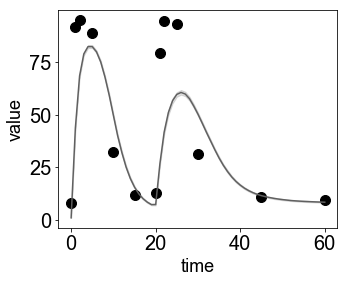

In [85]:
plotting.plt_ramp_cis(sims_M2b_kb_e2, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

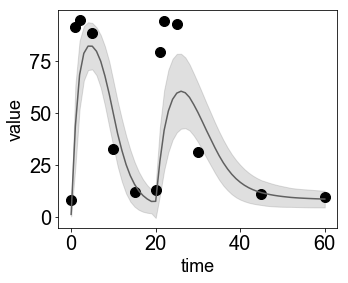

In [86]:
plotting.plt_ramp_cis(sims_M2b_kb_e2, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

### Investigating modality

PCA to see if modality can be explained by theta variance. Also, see if better scores are clustering together.

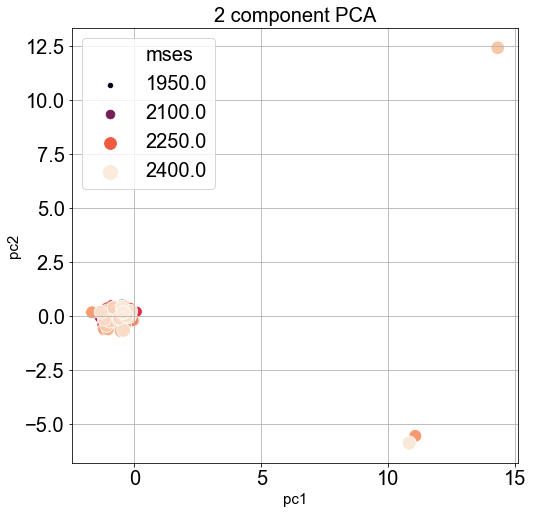

In [310]:
from sklearn.preprocessing import StandardScaler

df_top_thetas_e2_log = df_top_thetas_e2.apply(np.log10)

df_top_thetas_e2_log['mses'] = mses_e2_sort

x = df_top_thetas_e2_log.loc[:, labelnames].values
y = df_top_thetas_e2_log.loc[:,['mses']].values
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

finalDf = pd.concat([principalDf, df_top_thetas_e2_log[['mses']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

sns.scatterplot(x='pc1', y='pc2', hue='mses', size='mses',sizes=(20, 200), data=finalDf[finalDf['mses']<2400], palette="rocket")

ax.grid()

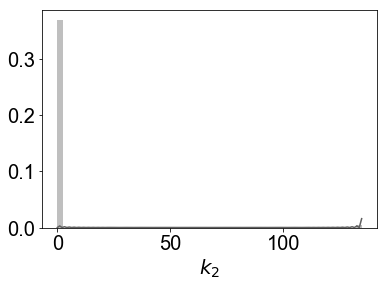

In [311]:
df_top_params_e2 = pd.DataFrame(thetas_e2)
df_top_params_e2.columns = labelnames
sns.distplot(df_top_params_e2[labelnames[7]])

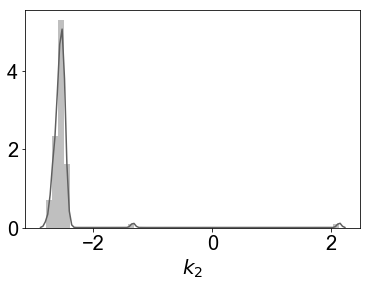

In [312]:
sns.distplot(np.log10(df_top_params_e2[labelnames[7]]))

<Figure size 432x288 with 0 Axes>

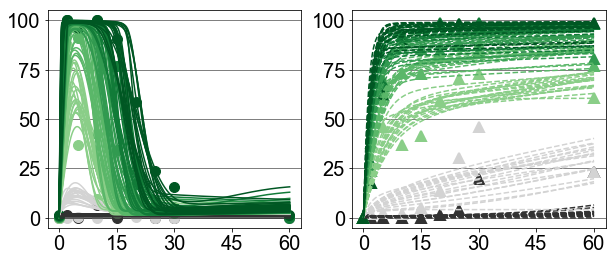

In [314]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 432x288 with 0 Axes>

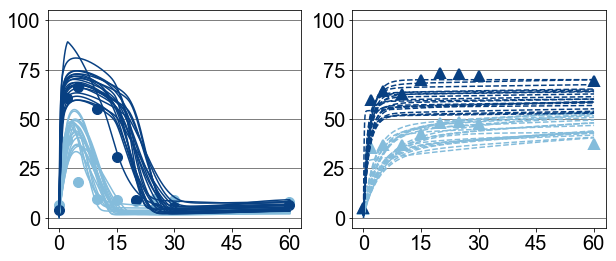

In [315]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

## Schedule 3 

In [26]:
probs = scaled_prob_mses(mses_e2_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.04581350015967375, 0.04420695917699438, 0.01740856777390851, 0.010984627425858172, 0.006264416361165047]
[0.00046399302101368016, 0.0004629476899533655, 0.00046290213564798233, 0.0004628176134900836, 0.0004627626278754925]


In [27]:
mses_e3, thetas_e3, count_e3 = run_schedule(thetas_e2_sort, probs, e3, num_theta_primes=1000)
mses_e3_sort, thetas_e3_sort = sort_mses_thetas(mses_e3, thetas_e3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


10% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


../../python_modules\model.py:341: RuntimeWarning: divide by zero encountered in double_scalars
  def M2c_kb(initials,t,total_protein,sig,params,run_type=None):
../../python_modules\model.py:341: RuntimeWarning: invalid value encountered in double_scalars
  def M2c_kb(initials,t,total_protein,sig,params,run_type=None):
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


100% complete.


In [28]:
df_top_thetas_e3 = pd.DataFrame(thetas_e3_sort)
df_top_thetas_e3.columns = labelnames

df_top_thetas_e3.to_csv('M2b_kb_thetas_e3.csv')

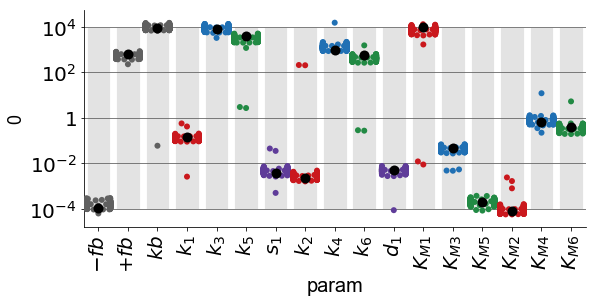

In [42]:
num_plt = 250
df_plt = pd.DataFrame(thetas_e3_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

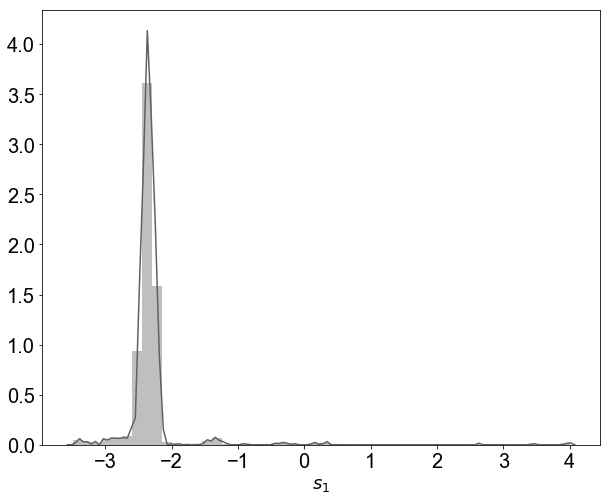

In [44]:
sns.distplot(np.log10(df_top_thetas_e3[labelnames[6]]))

<Figure size 720x576 with 0 Axes>

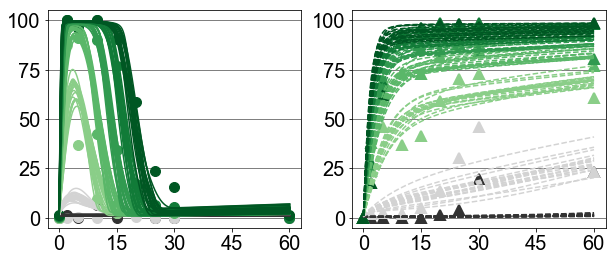

In [29]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e3_sort, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

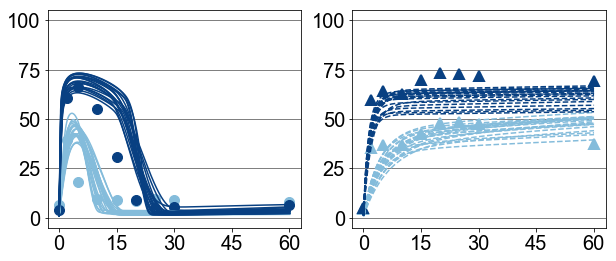

In [46]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e3_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [67]:
sims_M2b_kb_e3 = plotting.simdata_to_df(M2b_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


60% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


70% complete.
80% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


90% complete.


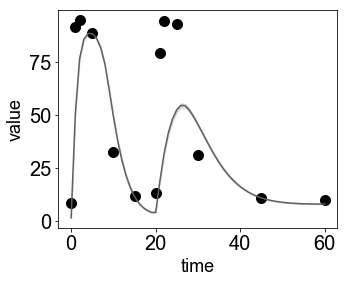

In [83]:
plotting.plt_ramp_cis(sims_M2b_kb_e3, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

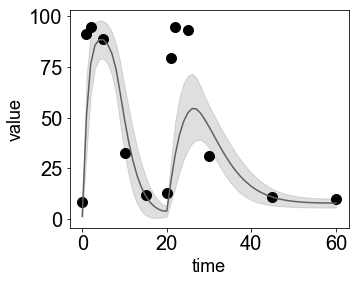

In [81]:
plotting.plt_ramp_cis(sims_M2b_kb_e3, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Schedule 4

In [30]:
probs = scaled_prob_mses(mses_e3_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.05419236514354046, 0.015106326931113728, 0.013100185832671005, 0.0055083205919825295, 0.005364964459523131]
[0.0005492963516959139, 0.0005484754472778218, 0.0005481973634224632, 0.0005477020585446308, 0.0005473976277125299]


In [31]:
mses_e4_M2b_kb, thetas_e4_M2b_kb, count_e4_M2b_kb = run_schedule(thetas_e3_sort, probs, e4, num_theta_primes=1000)
mses_e4_sort_M2b_kb, thetas_e4_sort_M2b_kb = sort_mses_thetas(mses_e4_M2b_kb, thetas_e4_M2b_kb)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10% complete.
20% complete.
30% complete.
40% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [32]:
df_top_thetas_e4_m2b_kb = pd.DataFrame(thetas_e4_sort_M2b_kb)
df_top_thetas_e4_m2b_kb.columns = labelnames
df_top_thetas_e3.to_csv('M2b_kb_thetas_e4.csv')

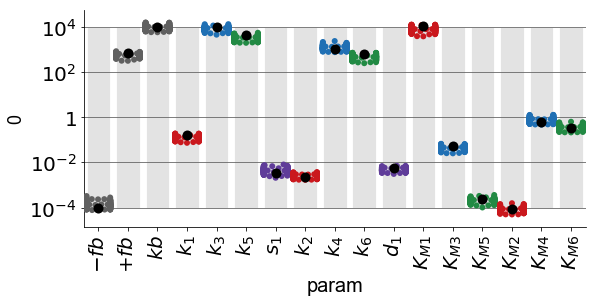

In [105]:
num_plt = 200
df_plt = pd.DataFrame(df_top_thetas_e4_m2b_kb[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

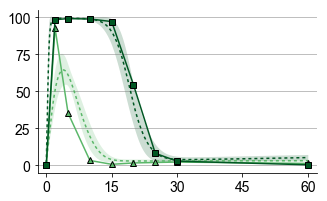

In [15]:
thetas_e4_sort = np.array(pd.read_csv("M2b_kb_thetas_e4.csv").drop(['Unnamed: 0'], axis=1))
# e4_sorted_mses, e4_sorted_thetas = model_supp.sort_mses_thetas(np.asarray(e4_mses), np.asarray(e4_thetas))

plotting.plt_param_cis(model_fxns, thetas_e4_sort, params_constants, initials,  [150000,550000], time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

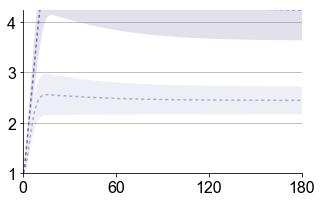

In [19]:
plotting.plt_param_cis(model_fxns, thetas_e4_sort, params_constants, initials,  [150000,350000], time, 3,
                        exp_data=None, exp_time=None, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

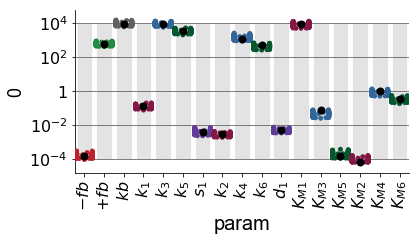

In [16]:
df_top_thetas_e4_m2b_kb = pd.DataFrame(thetas_e4_sort)
df_top_thetas_e4_m2b_kb.columns = labelnames
# df_top_thetas_e3.to_csv('M2b_kb_thetas_e4.csv')
num_plt = 200
df_plt = pd.DataFrame(df_top_thetas_e4_m2b_kb[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

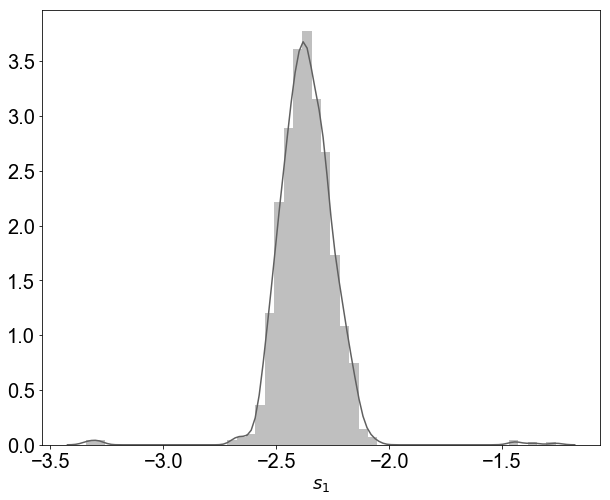

In [106]:
sns.distplot(np.log10(df_top_thetas_e4_m2b_kb[labelnames[6]]))

<Figure size 720x576 with 0 Axes>

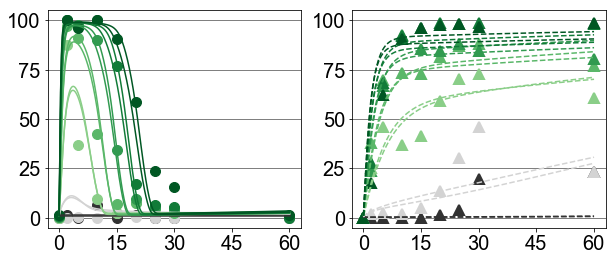

In [109]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e4_sort_M2b_kb, 2, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

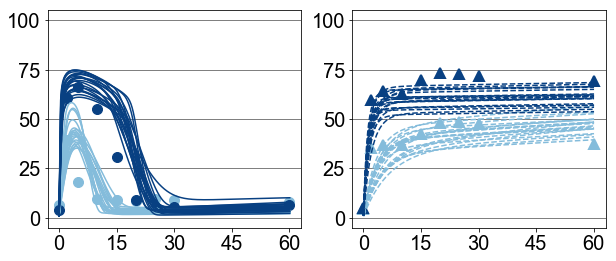

In [69]:
plotting.plt_param_behaviors(M2b_fxns, df_top_thetas_e4_m2b_kb, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [111]:
sims_M2c_kb_e4 = plotting.simdata_to_list(M2b_fxns, thetas_e4_sort_M2b_kb, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


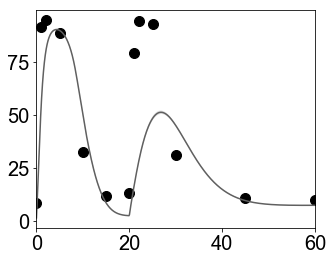

In [113]:
plotting.plt_ramp_cis(sims_M2c_kb_e4, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


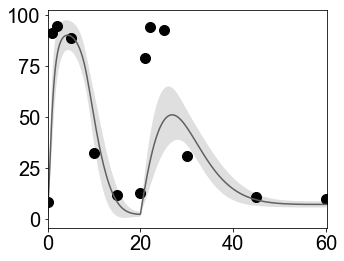

In [114]:
plotting.plt_ramp_cis(sims_M2c_kb_e4, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci = "sd")

In [165]:
M2b_inhib_sims = plotting.inhibdata_to_list(M2b_fxns, thetas_e4_sort_M2b_kb, params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


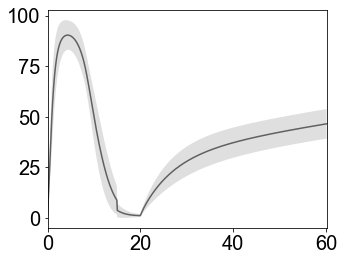

In [166]:
plotting.plt_inhib_cis(M2b_inhib_sims, time, ci="sd") #t>15 with ramp

# inhib

In [13]:
thetas_e4_sort = np.array(pd.read_csv("M2b_kb_thetas_e4.csv").drop(['Unnamed: 0'], axis=1))

In [14]:
model_fxns = model.Model(model.M2b_kb, model.simulate_t100a_experiment_M2a_kb, model.simulate_nopos_experiment_M2a_kb, model.M2b_kb_on_off)

In [23]:
inhib_sims = plotting.inhibdata_to_list(model_fxns, thetas_e4_sort[:20], params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)



0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


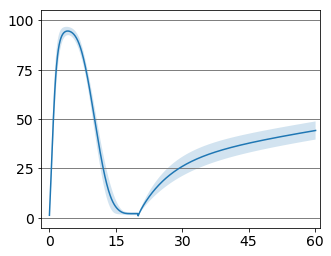

In [19]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


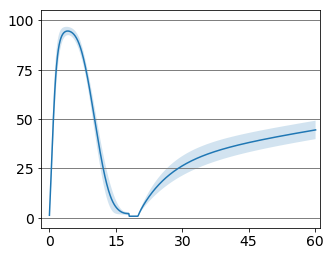

In [21]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


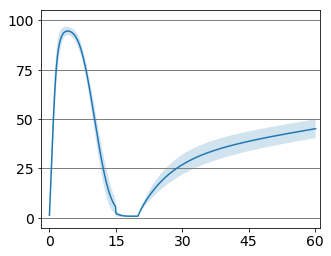

In [24]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp